In [471]:
from SimPEG import *
from SimPEG import EM
from pymatsolver import MumpsSolver
from scipy.constants import mu_0
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [497]:
cs, ncx, ncz, npad = 5, 25, 24, 20.
hx = [(cs,ncx), (cs,npad,1.3)]
hz = [(cs,npad,-1.3), (cs,ncz), (cs,npad,1.3)]
mesh = Mesh.CylMesh([hx,1,hz], '00C')    
sighalf = 1e-3
sigma = np.ones(mesh.nC)*1e-8
sigmahomo = sigma.copy()
mu = np.ones(mesh.nC)*mu_0
sigma[mesh.gridCC[:,-1]<0.] = sighalf
blkind  = np.logical_and(mesh.gridCC[:,0]<30., (mesh.gridCC[:,2]<0)&(mesh.gridCC[:,2]>-150)&(mesh.gridCC[:,2]<-50))
sigma[blkind] = 1e-1
mu[blkind] = mu_0*1.1
offset = 0.
frequency = np.logspace(1, 5, 21)
rx0 = EM.FDEM.Rx(np.array([[8., 0., 30.]]), 'bzr_sec')
rx1 = EM.FDEM.Rx(np.array([[8., 0., 30.]]), 'bzi_sec')
srcLists = []
nfreq = frequency.size
for ifreq in range(nfreq):
    src = EM.FDEM.Src.CircularLoop([rx0, rx1], frequency[ifreq], np.array([[0., 0., 30.]]), radius=5.)
    srcLists.append(src)
survey = EM.FDEM.Survey(srcLists)
iMap = Maps.IdentityMap(nP=int(mesh.nC))
maps = [('sigma', iMap), ('mu', iMap)]
prob = EM.FDEM.Problem_b(mesh, mapping=maps)
# prob.setPropMap(mapsdict)
prob.Solver = MumpsSolver
survey.pair(prob)
m = np.r_[sigma, mu]

(-200, 0.0)

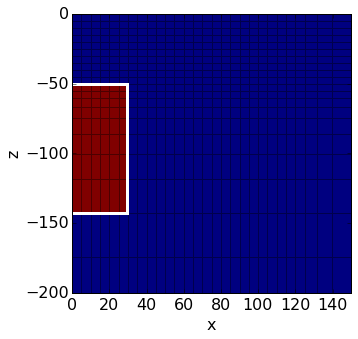

In [498]:
fig, ax = plt.subplots(1,1, figsize = (5,5))
mesh.plotImage(np.log10(sigma), grid=True, gridOpts={'alpha':0.4, 'color':'k'}, clim=(-3, -1),ax=ax)
ax.plot(np.r_[0, 29.75], np.r_[-50, -50], 'w', lw=3)
ax.plot(np.r_[29.5, 29.5], np.r_[-50, -142.5], 'w', lw=3)
ax.plot(np.r_[0, 29.5], np.r_[-142.5, -142.5], 'w', lw=3)
ax.set_xlim(0, 150.)
ax.set_ylim(-200, 0.)

In [499]:
survey0 = EM.FDEM.Survey(srcLists)
prob0 = EM.FDEM.Problem_b(mesh, mapping=maps)
prob0.Solver = MumpsSolver
survey0.pair(prob0)
m = np.r_[sigma, mu]
m0 = np.r_[sigma, np.ones(mesh.nC)*mu_0]
m00 = np.r_[np.ones(mesh.nC)*1e-8, np.ones(mesh.nC)*mu_0]

In [500]:
%%time
F = prob.fields(m)
F0 = prob.fields(m0)
F00 = prob.fields(m00)

CPU times: user 46.9 s, sys: 1.47 s, total: 48.4 s
Wall time: 50.2 s


In [501]:
import matplotlib
matplotlib.rcParams['font.size'] = 16

In [502]:
data = survey.dpred(m, u=F)
data0 = survey.dpred(m0, u=F0)
DATA = data.reshape((nfreq, 2))
DATA0 = data0.reshape((nfreq, 2))
DATAmu = DATA-DATA0
def vizdata(ifreq):
    figsize(7,5)
    plt.loglog(frequency, -(DATA[:,0]), 'k-')
    plt.loglog(frequency, (DATA[:,0]), 'k--')
    plt.loglog(frequency, -(DATA0[:,0]), 'k.')
    plt.loglog(frequency, -(DATA[:,1]), 'b-')
    plt.loglog(frequency, -(DATA0[:,1]), 'b.')
    plt.loglog(frequency, DATAmu[:,0], 'r--')
    plt.loglog(frequency, -DATAmu[:,0], 'r-')
    plt.xlabel("Freqency (Hz)")
    plt.ylabel("Bz field (T)")
    plt.legend(("Real F[$\sigma$, $\mu$] (-)", "Real F[$\sigma$, $\mu$] (+)", 
                "Real F[$\sigma$, $\mu_0$] (-)", 
                "Imag F[$\sigma$, $\mu$] (-)", "Imag F[$\sigma$, $\mu_0$] (-)", 
                "Real F[$\sigma$, $\mu$]-F[$\sigma$, $\mu_0$] (+)",
                "Real F[$\sigma$, $\mu$]-F[$\sigma$, $\mu_0$] (-)"
               ), bbox_to_anchor=(1.6,1.), fontsize = 14)
    plt.plot(np.ones(2)*frequency[ifreq], np.r_[1e-17, 1e-11], 'k:')

In [493]:
from ipywidgets import interactive, ToggleButtons

In [503]:
ifreq=3
def vizfields(ifreq=0, primsec="primary",realimag="real"):
    titles = ["F[$\sigma$, $\mu$]", "F[$\sigma$, $\mu_0$]", "F[$\sigma$, $\mu$]-F[$\sigma$, $\mu_0$]"]
    actind  = np.logical_and(mesh.gridCC[:,0]<200., (mesh.gridCC[:,2]>-400)&(mesh.gridCC[:,2]<200))

    if primsec=="secondary":
        bCCprim = (mesh.aveF2CCV*F00[:,'b'][:,ifreq]).reshape(mesh.nC, 2, order='F')        
        bCC = (mesh.aveF2CCV*F[:,'b'][:,ifreq]).reshape(mesh.nC, 2, order='F')-bCCprim
        bCC0 = (mesh.aveF2CCV*F0[:,'b'][:,ifreq]).reshape(mesh.nC, 2, order='F')-bCCprim
    elif primsec=="primary":
        bCC = (mesh.aveF2CCV*F[:,'b'][:,ifreq]).reshape(mesh.nC, 2, order='F')
        bCC0 = (mesh.aveF2CCV*F0[:,'b'][:,ifreq]).reshape(mesh.nC, 2, order='F')
        
    XYZ = mesh.gridCC[actind,:]
    X = XYZ[:,0].reshape((31,43), order='F')
    Z = XYZ[:,2].reshape((31,43), order='F')
    bx = bCC[actind,0].reshape((31,43), order='F')
    bz = bCC[actind,1].reshape((31,43), order='F')
    bx0 = bCC0[actind,0].reshape((31,43), order='F')
    bz0 = bCC0[actind,1].reshape((31,43), order='F')

    bxsec = (bCC[actind,0]-bCC0[actind,0]).reshape((31,43), order='F')
    bzsec = (bCC[actind,1]-bCC0[actind,1]).reshape((31,43), order='F')

    absbreal = np.sqrt(bx.real**2+bz.real**2)
    absbimag = np.sqrt(bx.imag**2+bz.imag**2)
    absb0real = np.sqrt(bx0.real**2+bz0.real**2)
    absb0imag = np.sqrt(bx0.imag**2+bz0.imag**2)
    
    absbrealsec = np.sqrt(bxsec.real**2+bzsec.real**2)
    absbimagsec = np.sqrt(bxsec.imag**2+bzsec.imag**2)

    fig = plt.figure(figsize(15,5))
    ax1 = plt.subplot(131)
    ax2 = plt.subplot(132)
    ax3 = plt.subplot(133)
    typefield="real"
    if realimag=="real":
        ax1.contourf(X, Z,np.log10(absbreal), 100)        
        ax1.quiver(X, Z,scale*bx.real/absbreal,scale*bz.real/absbreal,scale=0.2,width=0.005, alpha = 0.5)        
        ax2.contourf(X, Z,np.log10(absb0real), 100)        
        ax2.quiver(X, Z,scale*bx0.real/absb0real,scale*bz0.real/absb0real,scale=0.2,width=0.005, alpha = 0.5)        
        ax3.contourf(X, Z,np.log10(absbrealsec), 100)                
        ax3.quiver(X, Z,scale*bxsec.real/absbrealsec,scale*bzsec.real/absbrealsec,scale=0.2,width=0.005, alpha = 0.5)
    elif realimag=="imag":
        ax1.contourf(X, Z,np.log10(absbimag), 100)        
        ax1.quiver(X, Z,scale*bx.imag/absbimag,scale*bz.imag/absbimag,scale=0.2,width=0.005, alpha = 0.5)        
        ax2.contourf(X, Z,np.log10(absb0imag), 100)        
        ax2.quiver(X, Z,scale*bx0.imag/absb0imag,scale*bz0.imag/absb0imag,scale=0.2,width=0.005, alpha = 0.5)                
        ax3.contourf(X, Z,np.log10(absbimagsec), 100)        
        ax3.quiver(X, Z,scale*bxsec.imag/absbimagsec,scale*bzsec.imag/absbimagsec,scale=0.2,width=0.005, alpha = 0.5)

    ax = [ax1, ax2, ax3]
    ax3.text(30, 140, ("Frequency=%5.2f Hz")%(frequency[ifreq]))
    for i, axtemp in enumerate(ax):
        axtemp.plot(np.r_[0, 29.75], np.r_[-50, -50], 'w', lw=3)
        
        axtemp.plot(np.r_[29.5, 29.5], np.r_[-50, -142.5], 'w', lw=3)
        axtemp.plot(np.r_[0, 29.5], np.r_[-142.5, -142.5], 'w', lw=3)
        axtemp.plot(np.r_[0, 100.], np.r_[0, 0], 'w', lw=3)
        axtemp.set_ylim(-200, 100.)
        axtemp.set_xlim(10, 100.)        
        axtemp.set_title(titles[i])
Q = interactive(vizfields, ifreq=(0, frequency.size-1,1)
        ,primsec = ToggleButtons(options=["primary","secondary"])
        ,realimag = ToggleButtons(options=["real","imag"]))

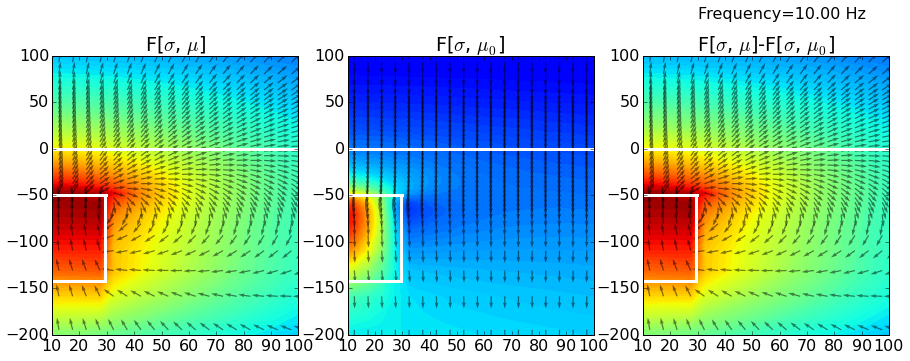

In [504]:
Q

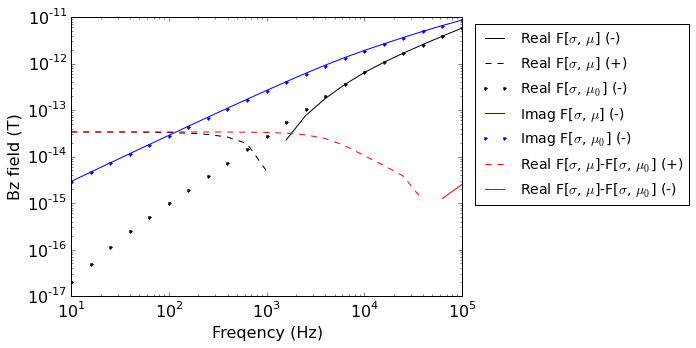

In [505]:
vizdata(Q.kwargs['ifreq'])